<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3</a></span><ul class="toc-item"><li><span><a href="#Generate-and-visualize-the-dataset" data-toc-modified-id="Generate-and-visualize-the-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate and visualize the dataset</a></span></li><li><span><a href="#Visualisation-of-dataset" data-toc-modified-id="Visualisation-of-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualisation of dataset</a></span></li><li><span><a href="#Implementation-of-Gaussian-Mixture-Model" data-toc-modified-id="Implementation-of-Gaussian-Mixture-Model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Implementation of Gaussian Mixture Model</a></span></li></ul></li></ul></div>

ZHU Fangda

In [1]:
%reset -f

In [2]:
%load_ext line_profiler

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.linalg import cholesky
from scipy.stats import multivariate_normal, norm
%matplotlib notebook

# Question 1

<div class="alert alert-info">

In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows:
<br>

\begin{equation}
\gamma_i(x) = \frac{ \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)}{\sum_{j=1}^K \pi_j \mathcal{N}(x ; \mu_j, \Sigma_j)}
\end{equation}
<br>
where $\pi_i \in [0,1]$ and $\mathcal{N}$ denotes the multivariate Gaussian distribution. A direct computation of these quantities might be problematic in practice since all the terms $\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$ might be very small, and we might end up with 0/0.   
<br>
Derive mathematically (don’t try to take the derivative!) and implement a function for numerically stable computation
of $\{\gamma_i\}_{i=1}^K$.  
<br>
Hint: first compute $l_i = \log \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$ in a numerically stable way (be careful when computing log det $\Sigma_i$). Then use a trick similar to the one we used for 'log sum exp'.
A</div>

In this report, we define $M$, the number of features, $K$, the number of distinct Gaussian distribution， and $N$, the number of samples.



According to the question,in order to avoid 0/0, we suppose that 
$$ l_i(x) = \ln\left(\pi_i  N\left(x;\mu_i,\Sigma_i\right)\right),i\in \mathbb[1,\dots,K]$$
We can write the formular like following:

$$
\begin{equation}
\begin{aligned}
\ln\gamma_i(x) &= l_i(x) - \ln\sum_{j=1}^K \exp{l_j(x)} \\
\end{aligned}
\end{equation}
$$
For the second item, we can apply the **logsumexp** trick.

Beside 
For each $l_i$, 

$\mathcal{N}(x;\mu_i,\Sigma_i)=\frac{e^{-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}}{\sqrt{(2\pi)^M|\Sigma_i|}})$

So

$$
l_i = \ln(\pi_i)-\ln(N\left(x;\mu_i,\Sigma_i\right)
$$

$$
l_i=\ln{\pi_i}-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)-\frac{M}{2}\ln(2\pi)-\frac{1}{2}\ln{|\Sigma_i|}
$$
where 
$$
|\Sigma|= det |\Sigma| = \Sigma_{\sigma \in S_n} \left(sgn(\sigma)\prod_{i=1}^{M}a_{i,\sigma}\right)
$$
If the $\Sigma$ has a very small or very larg determinant, then a call <code>det</code>  may overflow or underflow. So we have to find a method to avoid this problem.

This covariance matrix is a Hermitian positive-definite matrix. So we can apply the **Chokosky decomposition** and get
$$
\Sigma = LL^T = LU
$$
where $L$ is a lower triangular matrix and $U=L^T$ is a higher triangular matrix.So we can get 
$$
\det(\Sigma) = \det(LU)=\det(U)\det(L)=\prod \limits_{i=1}^{M}L_{i,i}\prod \limits_{i=1}^{M}U_{i,i}= \prod \limits_{i=1}^{M}L_{i,i}^2
$$
Thus
$$
\begin{aligned}
\ln|\Sigma| &= \ln|\prod \limits_{i=1}^{M}L_{i,i}^2| \\
&= 2\sum \limits_{i=1}\ln|L_{i,i}| \\
\end{aligned}
$$

In [4]:
def log_det(sgiam):
    '''
    Compute the determinant with a stable way.
    Params:
        sigma : the input matrix. This matrix must positif-definite
        
    Returns:
        det : determinant of simage
    
    '''
    L = cholesky(sigma, lower=True)
    return 2*np.sum(np.log(np.diag(L)))

In [5]:
# Test for the log_det method
sigma = np.array([[0.5, 0.25], [0.25, 0.5]]) / 1000000000000000000
np.allclose(log_det(sigma), np.log(np.linalg.det(sigma)))

True

Thus
$$
l_i(x)=\ln{\pi_i}-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)-\frac{M}{2}\ln(2\pi)-\sum \limits_{j=1}^{N}\ln|L_{j,j}| 
$$

Due to,
$$
\Sigma^{-1} = (L^T)^{-1}L = (L^{-1})^TL^{-1}
$$
We can contiue to simplify our formular by replacing $\Sigma^{-1}$ with $(L^{-1})^TL$, and we get
$$
l_i(x)=\ln{\pi_i}-\frac{1}{2}||L^{-1}(x-\mu_i)||^2-\frac{M}{2}\ln(2\pi)-\sum \limits_{j=1}^{M}\ln|L_{j,j}| 
$$

In [6]:
def log_gamma(x, pi, mu, sigma,):
    N = x.shape[0]
    items1 = np.log(pi)-N*0.5*np.log(2*np.pi)
    
    L = cholesky(sigma, lower=True)
    L_inv = np.linalg.inv(L)
    items2 = 0.5 * np.sum(L_inv.dot(x-mu)**2)
    items3 = np.sum(np.log(np.abs(np.diag(L))))
    return items1 -items2 - items3

In [7]:
# Test for the log_gamma function
X = -4 * np.array(list(np.ndindex(100, 100))) / 100 + 2
pi = [0.3, 0.2, 0.5]
mu = np.array([[0, 0], [1, 2], [2, 0]])
sigma = np.array([[[1., -0.25], [-0.25, 0.5]], [[0.5, 0.25], [0.25, 0.5]],
                  [[0.5, -0.25], [-0.25, 1]]])

In [8]:
for x in X:
    for i in range(3):
        for j in range(3):
            for k in range(3):
                test_val = log_gamma(x, pi[i], mu[j], sigma[k])
                except_val = np.log(pi[i] * stats.multivariate_normal.pdf(
                    x, mean=mu[j], cov=sigma[k]))
                if(not np.allclose(test_val, except_val)):
                    print(x,pi[i],mu[i], sigma[k])
                    print(('Excepted value:', except_val, 'Test value:', test_val))

According to the test, our function is correct. But the following test prove that our funciton is more robust when the covariance is very small.

D:\Users\zhufa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


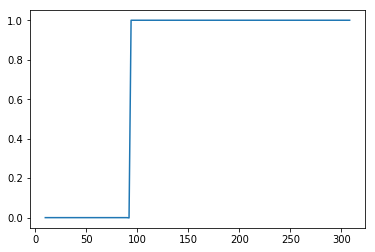

In [9]:
sigma = np.array([[1., -0.25], [-0.25, 0.5]])
diff = []
except_vals = []
test_vals = []

x = range(10,1000,2)
for i in x:
    except_val = np.log(pi[1]*stats.multivariate_normal.pdf(X[5], mean=mu[0], cov=sigma/i))
    test_val = log_gamma(X[5], pi[1], mu[0], sigma/i)
    diff.append(test_val - except_val)
    except_vals.append(except_val)
    test_vals.append(test_val)
    
diff = [1 if x == np.inf else x for x in diff]
except_vals = [1 if x == -np.inf else x for x in except_vals]
test_vals = [1 if x == -np.inf else x for x in test_vals]    
plt.figure()
plt.plot(x[:150],diff[:150])
plt.show()

No handles with labels found to put in legend.


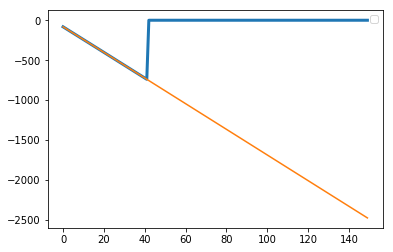

In [10]:
plt.figure()
plt.plot(except_vals[:150], lw=3)
plt.plot(test_vals[:150])
plt.legend()
plt.show()

When the covriance is enought small, the gamma gotten by **stats.multivariate_normal.pdf** become **-inf**, but our implementation can always get the values. So our implemention is more robust.

# Question 2

<div class="alert alert-info" role="alert">

Let us consider a Gaussian Mixture Model (GMM), given as follows:
<br>

\begin{equation}
p(x_n) = \sum_{i=1}^K \pi_i \mathcal{N}(x_n ; \mu_i, \Sigma_i)
\end{equation}

where $\{x_n\}_{n=1}^N $ is a set of observed data points. 

<br>Derive the M-Step of the Expectation-Maximization algorithm for this model, to find $\pi_{1:K}^{(t+1)}, \mu_{1:K}^{(t+1)}, \Sigma_{1:K}^{(t+1)}$, where $t$ denote the iteration number.
</div>

The Gaussian Mixtures Model give a linear super-position of Gaussians:
$$
p(x_n)=\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)
$$

Considerlog likehood:
<div class="card-body">
$$
\begin{align}
\ln p(X) &=  \underset{\mu_i, \Sigma_i}{argmax} \Sigma^N_{n=1}\ln p(x_n) \\
&= \sum\limits_{n=1}^N \underset{\mu_i, \Sigma_i}{argmax} \;\ln \left(\sum\limits_{i=1}^{K} \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)\right) 
\end{align}
$$

- For the means, we need

- $\frac{\partial{\ln p(X)}}{\partial{\mu_i}} = 0$

$$
\begin{equation}
\begin{aligned}
\frac{\partial{\ln p(x_n)}}{\partial{\mu_i}} &= \frac{1}{\sum\limits_{i=1}^{K}p(x_n|\pi_i,\mu_i,\Sigma_i)}\frac{\partial\sum\limits_{i=1}^{K}p(x_n|\pi_i,\mu_i,\Sigma_i)}{\partial\mu_k} \\
&= \frac{1}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}\frac{\partial\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\partial\mu_i}\\
&= \frac{1}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}\frac{\frac{\pi_ie^{-\frac{1}{2}(x_n-\mu_i)^T\Sigma_k^{-1}(x_n-\mu_i)}}{\sqrt{(2\pi)^k|\Sigma_i|}}}{\partial \mu_i} \\
&=\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}(-\Sigma_i^{-1}(x_n-\mu_i))\\
&=\gamma_i(x_n)\Sigma_i^{-1}(x_n-\mu_i) \\
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\frac{\partial{\ln p(X)}}{\partial{\mu_i}} &= \sum\limits_{n=1}^{N}\gamma_i(x_n)\Sigma_i^{-1}(x_n-\mu_i)
\end{aligned}
\end{equation}
$$
Thus 

$$\fbox{$\mu_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)x_n}{\sum\limits_{n=1}^{N}\gamma_i(x_n)}$}$$

For the covariance : we need
$$
\frac{\partial{logp(X)}}{\partial{\pi_i}} =0
$$

With the same methode, we hava
$$\frac{\partial{\ln p(X)}}{\partial{\Sigma_i}}=\sum\limits_{n=1}^{N}\gamma_i(x_n)((x_n-\mu_i)(x_n-\mu_i)^T-\Sigma_i)=0$$

Thus

$$\fbox {$\Sigma_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)((x_n-\mu_i)(x_n-\mu_i)^T}{\sum\limits_{n=1}^{N}\gamma_i(x_n)}$}$$


For the $\pi$, we need 
Because $\sum\limits_{i=1}^{K}\pi_i=1$ ans $\pi_i>0$, we add a Lagrange multiplier.Let

$$
\begin{equation}
\begin{aligned}
\frac{\partial{[logp(X)+\lambda(\sum\limits_{i=1}^{K}\pi_i-1)]}}{\partial{\pi_i}}&= 0 \\
\sum\limits_{n=1}^{N}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \pi_i\lambda &= 0 \\
\sum\limits_{i=1}^{K}\sum\limits_{n=1}^{N}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \sum\limits_{i=1}^{K}\pi_i\lambda &= 0 \\
\sum\limits_{n=1}^{N}\sum\limits_{i=1}^{K}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \lambda &= 0 \\
N+ \lambda &= 0 \\
\lambda &= -N \\
\end{aligned}
\end{equation}
$$

We we multiply  $\pi_i$  to both sides of the equation and get:


$\lambda+\sum\limits_{n=1}^{N}\sum\limits_{i=1}^{K}\gamma_i(x_n)=0 \rightarrow \lambda=-N$

Thus

$$\fbox{$\pi_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)}{N}$}$$


# Question 3

<div class="alert alert-info">
Consider the model given in Equation 1. 
<br>
Set $K = 3$, $\pi_1 = 0.3$, $\pi_2 = 0.2$, $\pi3 = 0.5$, $\mu_1 = [0; 0]$, $\mu_2 = [1; 2]$, $\mu_3 = [2; 0]$,
$\Sigma_1 = [1.00, −0.25; −0.25, 0.50]$, $\Sigma_2 = [0.50, 0.25; 0.25, 0.50]$, $\Sigma_3 = [0.50, −0.25; −0.25, 1]$.
</div>

In [11]:
K,N = 3, 1000
weight = [0.3, 0.2, 0.5]
mu = np.array([[0, 0], [1, 2], [2, 0]])
sigma = np.array([[[1., -0.25], [-0.25, 0.5]],
         [[0.5, 0.25], [0.25, 0.5]],
         [[0.5, -0.25], [-0.25, 1]]])

## Generate and visualize the dataset
<div class="alert alert-success">
Generate a dataset $\{x_n\}_{n=1}^N$ by using the model definition (set $N = 1000$). <br>Visualize the dataset.</div>

In [12]:
def generate_dataset(N, pi, mu, sigma):
    '''
    Generate dataset.
    
    Params:
    -------
        N : Number of samples
        pi : a array-list object containing weight for each distribution.
        mu : the means matrix with shape K*M where M is the number of feathre, K 
            is the number of the distributions
        sigma : a matrix containing the covariance of each distributions with 
            the shape K*M*M.
            
    Returns:
    --------
        df : a DataFrame cotaining all the features and the target.
    '''
    K, M = mu.shape
    data = np.zeros((N, M + 1))

    data[:, M] = np.random.choice( list(range(K)), p=pi, size=N)
    
    f = lambda x : multivariate_normal(mu[int(x[M]),:], sigma[int(x[M]), :, :]).rvs()

    data[:, :2] = np.apply_along_axis(f, axis=1, arr=data)

    df = pd.DataFrame(data, columns=['x', 'y', 'type'])
    df['type'] = df['type'].astype(np.int)

    return df

In [13]:
dataset = generate_dataset(N, weight, mu, sigma)
print("Mean:", mu)
print("var:", sigma)
pd.pivot_table(dataset, index='type', aggfunc=[np.mean, np.var])

Mean: [[0 0]
 [1 2]
 [2 0]]
var: [[[ 1.   -0.25]
  [-0.25  0.5 ]]

 [[ 0.5   0.25]
  [ 0.25  0.5 ]]

 [[ 0.5  -0.25]
  [-0.25  1.  ]]]


mean                 var          
             x         y         x         y
type                                        
0     0.167357 -0.123251  1.024176  0.505034
1     1.008166  2.022242  0.512442  0.480305
2     1.933267  0.037876  0.491988  1.045220

## Visualisation of dataset

In [14]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

In [16]:
def plot_kdn(weight,  mu, sigma,ax=None):
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
    X = np.arange(-5, 5, 0.1)
    Y = np.arange(-5, 5, 0.1)
    pts = np.array(np.meshgrid(X, Y)).T.reshape(-1,2)
    
    Z = np.zeros(len(pts))
    g=[]
    X, Y = np.meshgrid(X, Y)
    for i in range(len(mu)):
        g.append(stats.multivariate_normal.pdf(pts, mu[i], sigma[i]))
        Z = Z + weight[i]*g[i]
    
    
    if(ax==None):
        plt.figure()
        ax = plt.gca()
        
    CS = plt.contour(X, Y, Z.reshape(100,100).T, 20)
    plt.clabel(CS, inline=1, fontsize=10)
#     plt.scatter(mu[:,0], mu[:,1], s=weight*100)
    return plt.gca()
#     surf = ax.plot_surface(X, Y, Z.reshape(100,100), rstride=1, cstride=1, cmap=plt.get_cmap('coolwarm'),
#             linewidth=0, antialiased=True)
#     fig.colorbar(surf, shrink=0.5, aspect=5)

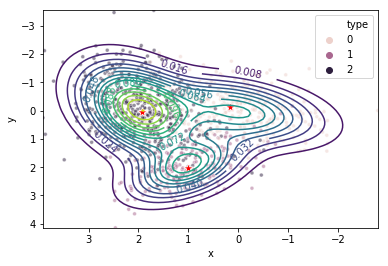

In [17]:
ax = plot_kdn(weight, mu, sigma)
ax.set_xlim([dataset.x.max(), dataset.x.min()])
ax.set_ylim([dataset.y.max(), dataset.y.min()])
ax = sns.scatterplot(x="x", y="y", data=dataset, hue="type", ax= ax,  s=15, alpha=0.5)
ax = sns.scatterplot(x='x', y='y', data=dataset.groupby(by = 'type').mean(), ax=ax, marker='*' ,color='r',s=100)

## Implementation of Gaussian Mixture Model

In [18]:
class Gaussian_Mixture_Model:

    def log_gamma(self, x, pi, mu, sigma):
        N = x.shape[0]
        items1 = np.log(pi)-N*0.5*np.log(2*np.pi)

        L = cholesky(sigma, lower=True)
        L_inv = np.linalg.inv(L)
        items2 = 0.5 * np.sum(L_inv.dot(x-mu)**2)
        items3 = np.sum(np.log(np.abs(np.diag(L))))
        return items1 -items2 - items3


    def _logsum(self, vals, axis=None, keepdims=False):
        if(axis==None):
            l_max = np.max(vals)
            return np.max(vals) + np.log(np.sum(np.exp(vals - l_max)))
        else:
            vals = vals.T if(axis ==1) else vals
            l_max = np.max(vals, axis=0)
            return l_max + np.log(np.sum(np.exp(vals - l_max), axis=0))
    
    
    def __init__(self, K, n_iter=1000, tol=1e-6, rand_state=None,
                 verbose=False):
        '''
        Create a new Gaussian Mixture Model estimator.

        Input:
        ------
            K : the number of cluster
            n_iter : set the max number of iteration
            verbose : show the processing information if True
        '''

        self.K, self.n_iter, self.tol = K, n_iter, tol
        self.rand_state, self.verbose = rand_state, verbose

        if (self.rand_state == None):
            self.uniform = np.random.uniform
        else:
            self.uniform = np.random.RandomState(rand_state).uniform

    def __init_param(self, X):
        '''
            Initialization of the parameter of distribution.
        '''

        self.nb_samples, self.nb_features = X.shape
        
        # weight for each gaussian distribution
        self.weight = np.random.rand(self.K)
        self.weight = self.weight / np.linalg.norm(self.weight, 1)
        
        # Save gamma value for each condition, each line for a distribution,
        # column for the sample
        self.gamma = np.zeros(shape=(self.K,self.nb_samples))
        # p(i,j) = pi_i * N(x_j, means[i], mu[i])
        self.__prob = np.zeros(shape=(self.K, self.nb_samples))
        
        
        self.X = np.array(X, dtype=np.float64)
        X_max = np.max(self.X)
        X_min = np.min(self.X)
        X_band = X_max - X_min
        
        self.cov = (X_max-X_min) * \
            self.uniform(size=(self.K,self.nb_features,self.nb_features))
        
        self.mean = (X_max - X_min) * self.uniform(
            size=(self.K, self.nb_features)) + X_min
        
        for i in range(self.K):
            self.cov[i] = self.cov[i].dot(self.cov[i].T)
        
        self._get_prob()
        
        if (self.verbose):
            print(('Initial parameter: \n\t pi:\n{}, \n\tmean:\n{} \n\tcov:\n{}'.format(
                self.weight, self.mean, self.cov)))
            
    
            
    def fit(self, X):
        self.__init_param(X)
        _old_likehood = 0
        self._likehood = [self._evaluation()]

        for cnt in range(self.n_iter):       
            self._e_step()
            self._m_step()
            self._get_prob()
            self._likehood.append(self._evaluation())
            
            if (self.verbose):
                print(("Number iteration:{}, log likehood:{} diff:{:e}".format(
                    cnt, self.log_likehood, np.abs(self._likehood[cnt]-self._likehood[cnt-1]))))
                if(np.abs(self._likehood[cnt]-self._likehood[cnt-1]) >1.0 or cnt%20==0):
                    self.draw_plot()
            
            if( np.abs(self._likehood[cnt]-self._likehood[cnt-1]) < self.tol):
                break;
                
        
        if(self.verbose):
            print(('Initial value: \n ----------pi:\n{}, \n----------mean:\n{} \n----------cov:\n{}'.format(
                self.weight, self.mean, self.cov)))
        
        

    def _e_step(self):
        diff = self.__prob - np.max(self.__prob, axis=0)
        self.gamma = diff - np.log(np.sum(np.exp(diff), axis=0))        


    def _m_step(self):
        max_gamma = np.max(self.gamma, axis=1)
        exp_diff = np.exp(self.gamma.T- max_gamma).T
        divisor = np.sum(exp_diff, axis=1)
        self.mean = (exp_diff.dot(self.X).T / np.sum(exp_diff, axis=1)).T
#         print('mean',self.mean)
        
        self.weight= np.exp(max_gamma) / self.nb_samples * np.sum(exp_diff, axis=1) 
#         print('weight', self.weight)
        
        for i in range(self.K):
#             print('X', self.X.shape, exp_diff[i,:].shape, (X - self.mean[i]).shape )
            self.cov[i] = (exp_diff[i,:] * (self.X - self.mean[i]).T).dot(self.X - self.mean[i]) /  divisor[i]
            
#         print('cov',i, self.cov)
            

    def _get_prob(self):
        for k in range(self.K):
            for i in range(self.nb_samples):
                self.__prob[k,i] = self.log_gamma(self.X[i, :], self.weight[k], self.mean[k], self.cov[k])

    def predicate_proba(self, val_X):
        nb_val_sample = len(val_X)
        prob_matrix = np.zeros(shape=(self.K, len(val_X)))
                
        for k in range(self.K):
            for i in range(nb_val_sample):
                prob_matrix = self.log_gamma(val_X[i, :], self.weight[k], self.mean[k], self.cov[k])
            
        return prob_matrix
    
    def predicate(self, val_X):
        predicate_proba(self, val_X)
        return np.argmax(prob_matrix, axis=0)
        
    def _evaluation(self):
        ## Max value for each xn
        max_col = np.max(self.__prob,axis=0)
        self.log_likehood =  np.sum(max_col + np.log(np.sum(np.exp(self.__prob - max_col), axis=0)))
        
        return self.log_likehood

    def __repr__(self):
        return self.__str__()

    def draw_result(self, ax=None):
        if(ax==None):
            plt.figure()
            ax = plt.gca()

        
        df = pd.DataFrame(self.X, columns=['x','y'])
        
        plot_ellipses(ax, self.weight, self.mean, self.cov)
        ax.set_xlim([df.x.max(), df.x.min()])
        ax.set_ylim([df.y.max(), df.y.min()])
        df['category'] = np.argmax(self.__prob, axis=0)
        sns.scatterplot(x="x", y="y", data=df, hue="category", ax= ax)
    
    def draw_ked(self, ax=None):
        if(ax==None):
            plt.figure()
            ax = plt.gca()
            
        dataset = pd.DataFrame(self.X, columns=['x','y'])
        dataset['category'] = np.argmax(self.__prob, axis=0)
        plot_kdn(self.weight, self.mean, self.cov, ax=ax)
        ax.set_xlim([dataset.x.max(), dataset.x.min()])
        ax.set_ylim([dataset.y.max(), dataset.y.min()])
        ax = sns.scatterplot(x="x", y="y", data=dataset, hue="category", ax= ax,  s=15, alpha=0.5)
        ax = plt.scatter(self.mean[:,0], self.mean[:,1],s = self.weight *100)
        
    def draw_plot(self):
        fig,axs = plt.subplots(1,2,figsize=(10,5))
        self.draw_ked(axs[1])
        self.draw_result(axs[0])
        plt.show()
        
    def __str__(self):
        return "Gaussian_Mixture_Model(self, {}, n_iter = {}, tol={}, rand_state={}, verbose = {})".format(
            self.K, self.n_iter, self.tol, self.rand_state, self.verbose)

<div class='alert alert-info'>
(a) Forget about the true parameters π1:K, µ1:K, and Σ1:K for now. By only considering the dataset fxngN n=1
that is generated in the previous step, run the EM algorithm after randomly initializing the parameter
estimates π(0)
1:K, µ
(0)
1:K, and Σ(0) 1:K. Visualize the intermediate results by plotting the contours of the estimated
Gaussians.
</div>

Initial parameter: 
	 pi:
[0.18495469 0.60877423 0.20627107], 
	mean:
[[ 2.37667155  2.67599539]
 [-2.19964852  4.10160964]
 [ 2.57255852 -2.74686362]] 
	cov:
[[[15.64264862 31.61123293]
  [31.61123293 87.88945625]]

 [[84.03918327 46.18383377]
  [46.18383377 28.41657414]]

 [[78.94825925 62.85353456]
  [62.85353456 57.48966438]]]
Number iteration:0, log likehood:-3090.7735030766394 diff:3.194315e+03


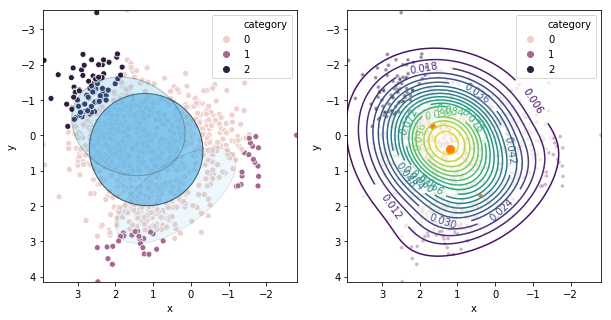

Number iteration:1, log likehood:-3077.519756069414 diff:3.194315e+03


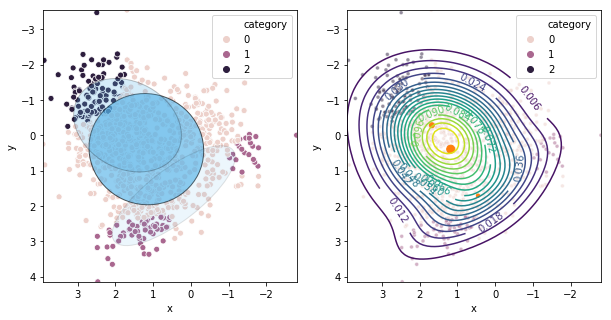

Number iteration:2, log likehood:-3069.487357283289 diff:1.325375e+01


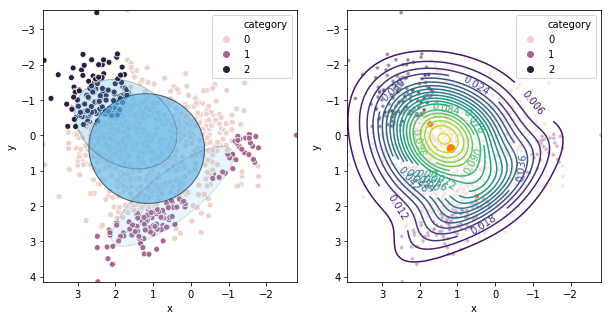

Number iteration:3, log likehood:-3062.710469643893 diff:8.032399e+00


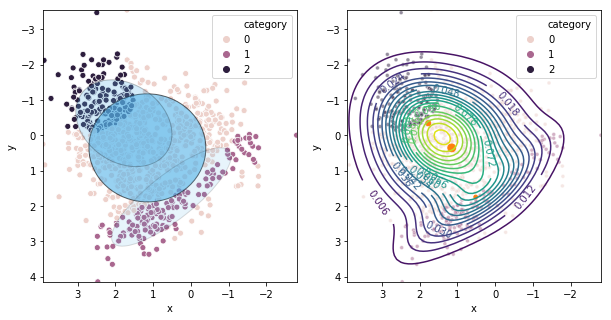

Number iteration:4, log likehood:-3055.589311271002 diff:6.776888e+00


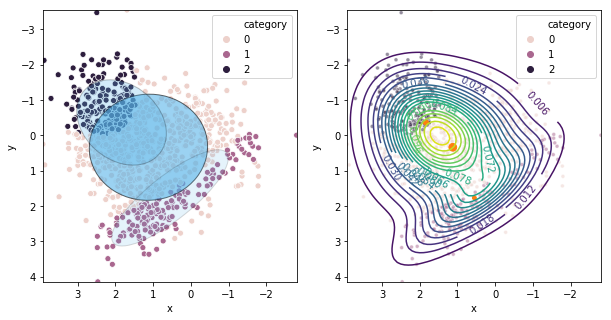

Number iteration:5, log likehood:-3047.442544037716 diff:7.121158e+00


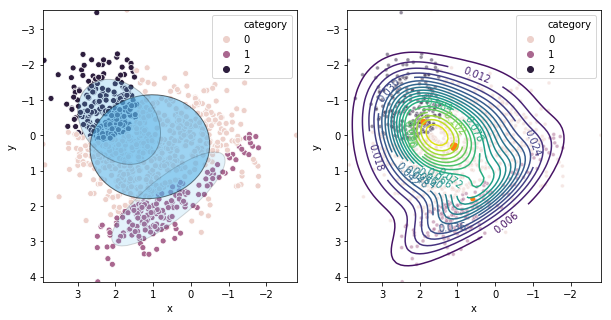

Number iteration:6, log likehood:-3038.66538768747 diff:8.146767e+00


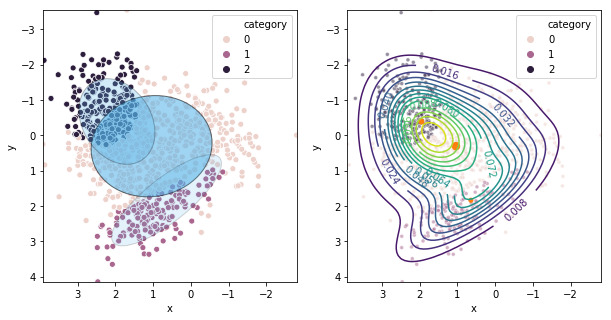

Number iteration:7, log likehood:-3030.2967500217587 diff:8.777156e+00


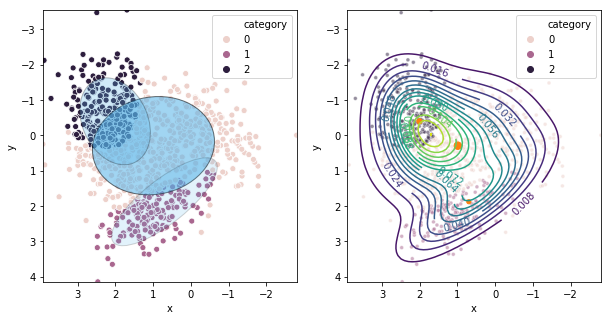

Number iteration:8, log likehood:-3022.8253128135284 diff:8.368638e+00


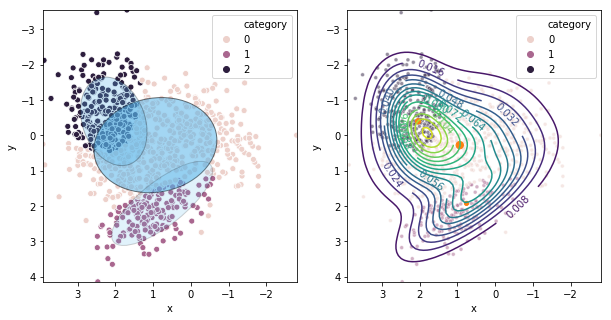

Number iteration:9, log likehood:-3015.8333442872936 diff:7.471437e+00


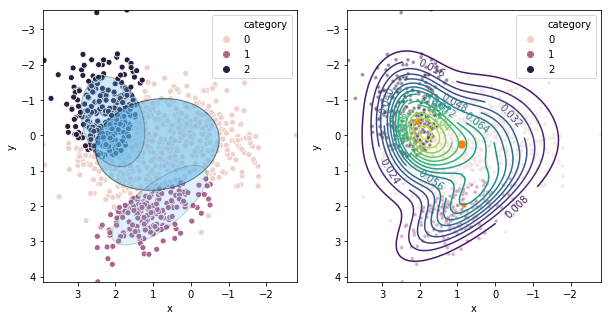

Number iteration:10, log likehood:-3008.6886667468466 diff:6.991969e+00


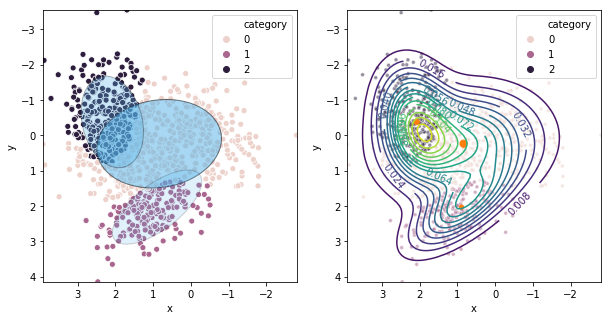

Number iteration:11, log likehood:-3001.34641711949 diff:7.144678e+00


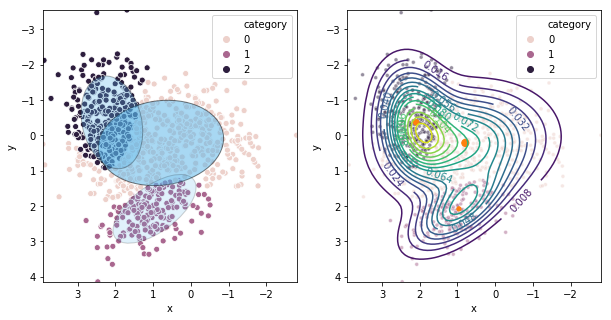

Number iteration:12, log likehood:-2994.849218941499 diff:7.342250e+00


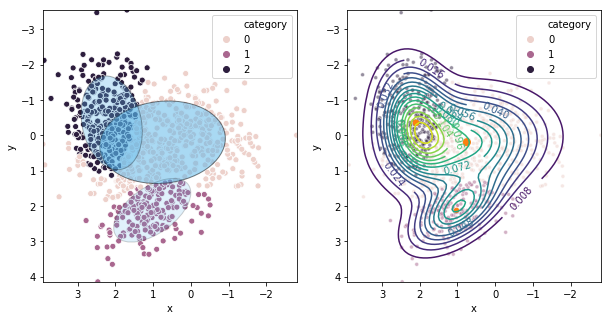

Number iteration:13, log likehood:-2990.4611024834585 diff:6.497198e+00


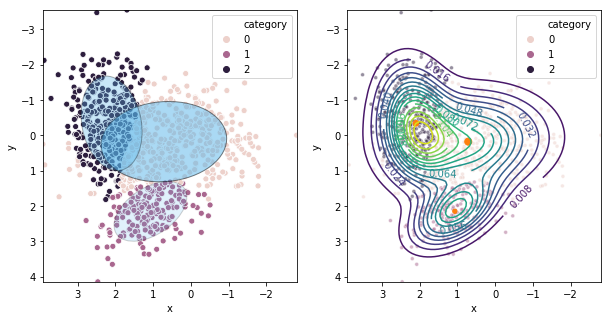

Number iteration:14, log likehood:-2988.1498557497616 diff:4.388116e+00


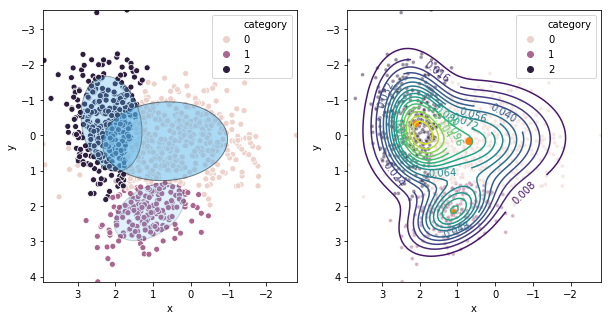

Number iteration:15, log likehood:-2987.0234035973895 diff:2.311247e+00


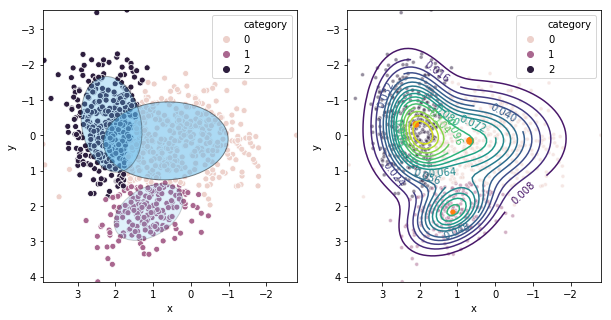

Number iteration:16, log likehood:-2986.4041836165316 diff:1.126452e+00


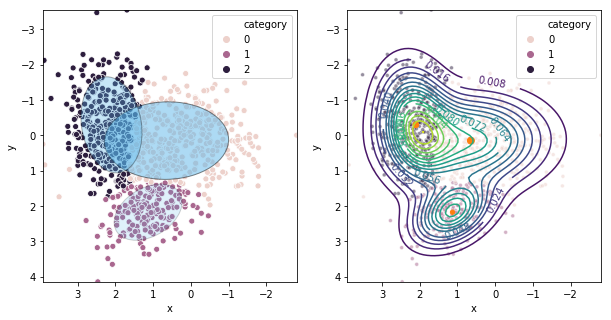

Number iteration:17, log likehood:-2985.990571510184 diff:6.192200e-01
Number iteration:18, log likehood:-2985.6707013111063 diff:4.136121e-01
Number iteration:19, log likehood:-2985.40237079205 diff:3.198702e-01
Number iteration:20, log likehood:-2985.167362199494 diff:2.683305e-01


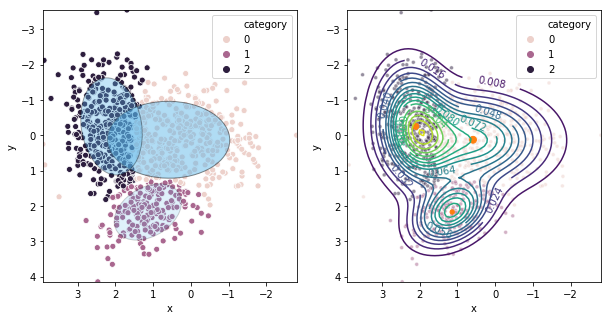

Number iteration:21, log likehood:-2984.956336221849 diff:2.350086e-01
Number iteration:22, log likehood:-2984.7637388856983 diff:2.110260e-01
Number iteration:23, log likehood:-2984.5858882235516 diff:1.925973e-01
Number iteration:24, log likehood:-2984.420145228989 diff:1.778507e-01
Number iteration:25, log likehood:-2984.2645050099027 diff:1.657430e-01
Number iteration:26, log likehood:-2984.1173749364734 diff:1.556402e-01
Number iteration:27, log likehood:-2983.9774459017863 diff:1.471301e-01
Number iteration:28, log likehood:-2983.843613688724 diff:1.399290e-01
Number iteration:29, log likehood:-2983.714928768364 diff:1.338322e-01
Number iteration:30, log likehood:-2983.5905629194126 diff:1.286849e-01
Number iteration:31, log likehood:-2983.4697862056337 diff:1.243658e-01
Number iteration:32, log likehood:-2983.351950610067 diff:1.207767e-01
Number iteration:33, log likehood:-2983.236478146933 diff:1.178356e-01
Number iteration:34, log likehood:-2983.122852124153 diff:1.154725e-01

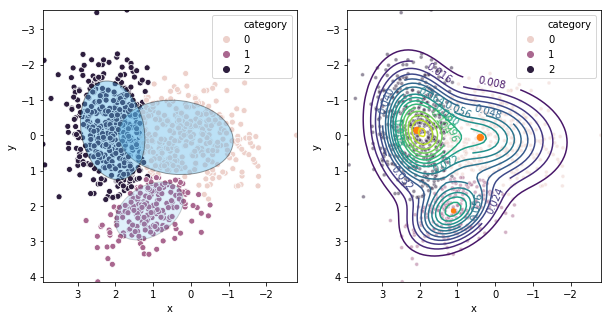

Number iteration:41, log likehood:-2982.346345339873 diff:1.105894e-01
Number iteration:42, log likehood:-2982.234756686083 diff:1.110112e-01
Number iteration:43, log likehood:-2982.122474060779 diff:1.115887e-01
Number iteration:44, log likehood:-2982.009418927241 diff:1.122826e-01
Number iteration:45, log likehood:-2981.895549419953 diff:1.130551e-01
Number iteration:46, log likehood:-2981.7808586597507 diff:1.138695e-01
Number iteration:47, log likehood:-2981.665372691319 diff:1.146908e-01
Number iteration:48, log likehood:-2981.54914805095 diff:1.154860e-01
Number iteration:49, log likehood:-2981.43226900198 diff:1.162246e-01
Number iteration:50, log likehood:-2981.3148444986164 diff:1.168790e-01
Number iteration:51, log likehood:-2981.197004954698 diff:1.174245e-01
Number iteration:52, log likehood:-2981.07889890208 diff:1.178395e-01
Number iteration:53, log likehood:-2980.960689624225 diff:1.181061e-01
Number iteration:54, log likehood:-2980.8425518453773 diff:1.182093e-01
Number

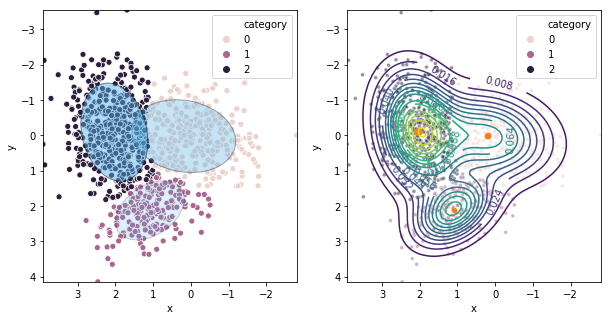

Number iteration:61, log likehood:-2980.0332943970006 diff:1.137739e-01
Number iteration:62, log likehood:-2979.9224411168216 diff:1.123990e-01
Number iteration:63, log likehood:-2979.8132957972903 diff:1.108533e-01
Number iteration:64, log likehood:-2979.7060111524643 diff:1.091453e-01
Number iteration:65, log likehood:-2979.6007295863774 diff:1.072846e-01
Number iteration:66, log likehood:-2979.497582606015 diff:1.052816e-01
Number iteration:67, log likehood:-2979.3966903946475 diff:1.031470e-01
Number iteration:68, log likehood:-2979.2981615267327 diff:1.008922e-01
Number iteration:69, log likehood:-2979.202092807418 diff:9.852887e-02
Number iteration:70, log likehood:-2979.108569221669 diff:9.606872e-02
Number iteration:71, log likehood:-2979.0176639799574 diff:9.352359e-02
Number iteration:72, log likehood:-2978.9294386492024 diff:9.090524e-02
Number iteration:73, log likehood:-2978.8439433591684 diff:8.822533e-02
Number iteration:74, log likehood:-2978.761217075781 diff:8.549529e

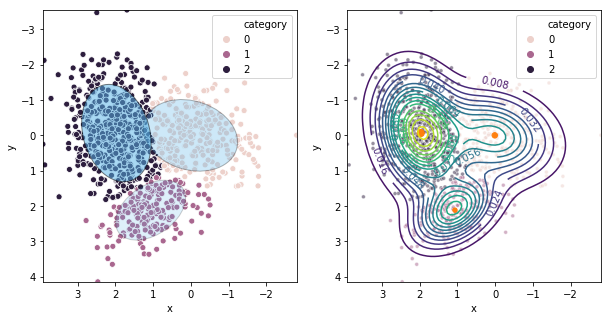

Number iteration:81, log likehood:-2978.2607699428036 diff:6.587112e-02
Number iteration:82, log likehood:-2978.200390057728 diff:6.310814e-02
Number iteration:83, log likehood:-2978.1426969366926 diff:6.037989e-02
Number iteration:84, log likehood:-2978.087642905085 diff:5.769312e-02
Number iteration:85, log likehood:-2978.0351747062996 diff:5.505403e-02
Number iteration:86, log likehood:-2977.98523409819 diff:5.246820e-02
Number iteration:87, log likehood:-2977.9377584425206 diff:4.994061e-02
Number iteration:88, log likehood:-2977.8926812832115 diff:4.747566e-02
Number iteration:89, log likehood:-2977.849932909513 diff:4.507716e-02
Number iteration:90, log likehood:-2977.809440900634 diff:4.274837e-02
Number iteration:91, log likehood:-2977.771130648808 diff:4.049201e-02
Number iteration:92, log likehood:-2977.734925858159 diff:3.831025e-02
Number iteration:93, log likehood:-2977.700749017204 diff:3.620479e-02
Number iteration:94, log likehood:-2977.6685218432553 diff:3.417684e-02
N

In [19]:
estimator1 = Gaussian_Mixture_Model( K, n_iter=100, tol=1e-4, rand_state=None,
                 verbose=True)
estimator1.fit(dataset.iloc[:,:2].values)

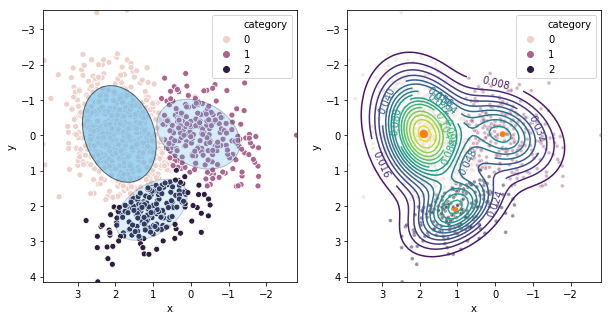

In [27]:
estimator1 = Gaussian_Mixture_Model(K=3,  n_iter=100, verbose=False, rand_state=1)
estimator1.fit(dataset[['x','y']])
estimator1.draw_plot()

<div class='alert alert-info'>
(b) While running the EM algorithm, compute the log-likelihood. Plot the log-likelihood vs iterations (be
careful about numerical stability!).
</div>

In [21]:
estimator1 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=1)
estimator1.fit(dataset[['x','y']])

estimator2 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=15)
estimator2.fit(dataset[['x','y']])

estimator3 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=100)
estimator3.fit(dataset[['x','y']])


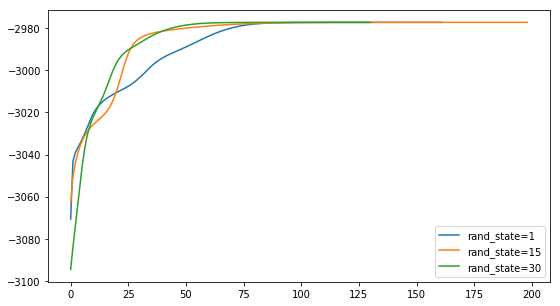

In [22]:
plt.figure(figsize=(9,5))
plt.plot(estimator1._likehood[1:200], label='rand_state=1')
plt.plot(estimator2._likehood[1:200], label='rand_state=15' )
plt.plot(estimator3._likehood[1:200], label='rand_state=30')
plt.legend()
plt.show()

We can find the likehood change smoothly and converge fastly.

<div class='alert alert-info'>
c) Run the EM algorithm with different initializations for π1: (0) K, µ(0) 1:K, and Σ(0) 1:K. How sensitive is the algorithm
for different initial values?
</div>

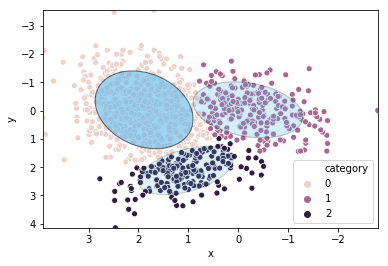

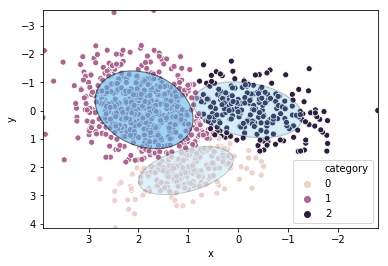

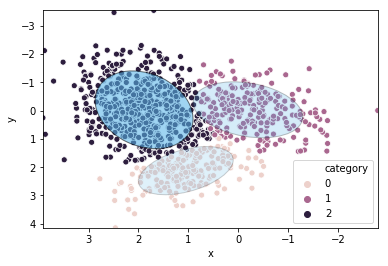

In [23]:
estimator1.draw_result()
estimator2.draw_result()
estimator3.draw_result()

In [24]:
np.set_printoptions(precision=2)
print('----------Origin param-----------')
print(mu)
print(sigma)
print('----------First estimator--------')
print(estimator1.mean)
print(estimator1.cov)
print('----------First estimator2--------')
print(estimator2.mean)
print(estimator2.cov)
print('----------First estimator3--------')
print(estimator3.mean)
print(estimator3.cov)
np.set_printoptions(precision=None)

----------Origin param-----------
[[0 0]
 [1 2]
 [2 0]]
[[[ 1.   -0.25]
  [-0.25  0.5 ]]

 [[ 0.5   0.25]
  [ 0.25  0.5 ]]

 [[ 0.5  -0.25]
  [-0.25  1.  ]]]
----------First estimator--------
[[ 1.89 -0.03]
 [-0.2  -0.03]
 [ 1.05  2.12]]
[[[ 0.48 -0.16]
  [-0.16  0.95]]

 [[ 0.6  -0.14]
  [-0.14  0.49]]

 [[ 0.45  0.18]
  [ 0.18  0.36]]]
----------First estimator2--------
[[ 1.05  2.12]
 [ 1.89 -0.03]
 [-0.2  -0.03]]
[[[ 0.45  0.18]
  [ 0.18  0.36]]

 [[ 0.48 -0.16]
  [-0.16  0.95]]

 [[ 0.6  -0.14]
  [-0.14  0.49]]]
----------First estimator3--------
[[ 1.05  2.12]
 [-0.2  -0.03]
 [ 1.89 -0.03]]
[[[ 0.45  0.18]
  [ 0.18  0.36]]

 [[ 0.6  -0.14]
  [-0.14  0.49]]

 [[ 0.48 -0.16]
  [-0.16  0.95]]]


Althougth the initial value is diffrent, but we get almost the  same distrubiton. So the result gotten by the EM algorithm is not semsible for initiall values. But according to the log_likehood curve for diffrent initial value, we can find that the initial value have a great influence for the speed of converge. 